# Mismatch between TWSA<sub>GLDAS</sub> and TWSA<sub>GRACE</sub>


In [1]:
#!pip install geopandas rasterio rioxarray xarray numpy

import geopandas as gpd
import rioxarray
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from rasterio.enums import Resampling

#### 1. Read data

In [2]:
ds_grace = xr.open_mfdataset('./data/GRACE/TWSA_M_2002_2016_India_05.nc4')
ds_gldas = xr.open_mfdataset('./data/GLDAS/processed/TWSA_M_2002_2016_India_03125.nc4')

da_grace = ds_grace['twsa_grace']
da_gldas = ds_gldas['twsa_gldas']

# for some reason, projection info is not saved -> temporary fix
da_gldas.rio.set_spatial_dims(x_dim='lon', y_dim='lat', inplace=True)
da_gldas.rio.write_crs('epsg:4326', inplace=True)

<xarray.DataArray 'twsa_gldas' (time: 177, lat: 128, lon: 128)> Size: 12MB
dask.array<open_dataset-twsa_gldas, shape=(177, 128, 128), dtype=float32, chunksize=(177, 128, 128), chunktype=numpy.ndarray>
Coordinates:
  * lon          (lon) float64 1kB 60.16 60.47 60.78 61.09 ... 99.22 99.53 99.84
  * lat          (lat) float64 1kB 47.59 47.28 46.97 46.66 ... 8.531 8.219 7.906
  * time         (time) datetime64[ns] 1kB 2002-04-01 2002-05-01 ... 2016-12-01
    spatial_ref  int64 8B 0
Attributes:
    grid_mapping:  spatial_ref

#### 2. Linear interpolation of GRACE

In [3]:
filled_da_grace = da_grace.resample(time="MS").interpolate("linear")

#### 3. Plot time series for an example location in NW India (30N 80E)

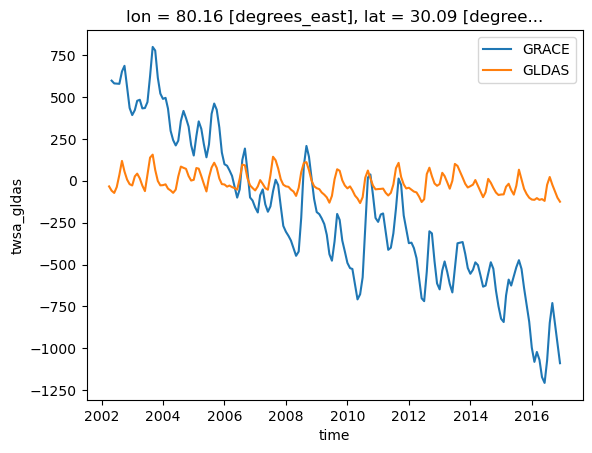

In [4]:
filled_da_grace.sel(lat=30, lon=80, method='nearest').plot(label="GRACE")
da_gldas.sel(lat=30, lon=80, method='nearest').plot(label="GLDAS")
plt.legend()

#### 4. Calculate the difference without resampling

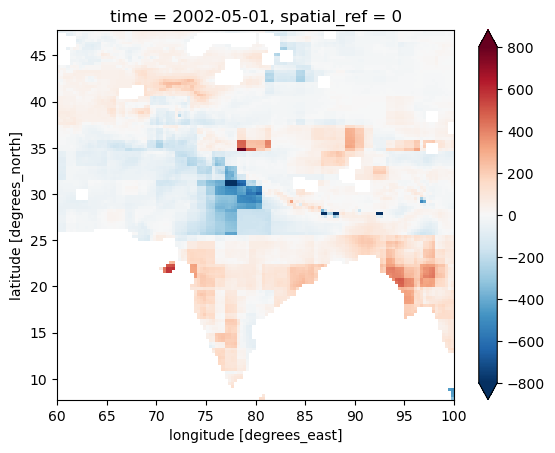

In [5]:
lat_gldas = da_gldas['lat'].values
lat_grace = filled_da_grace['lat'].values
lon_gldas = da_gldas['lon'].values
lon_grace = filled_da_grace['lon'].values

# Function to find the index of the nearest value in an array
def find_nearest_index(array, values):
    idx = np.abs(array[:, np.newaxis] - values).argmin(axis=0)
    return idx

# Find the indices of the nearest latitudes and longitudes
nearest_lat_indices = find_nearest_index(lat_grace, lat_gldas)
nearest_lon_indices = find_nearest_index(lon_grace, lon_gldas)

# calculate the difference
difference = da_gldas.to_numpy() - filled_da_grace[:, nearest_lat_indices, nearest_lon_indices].to_numpy()

# Create a DataArray for the difference
difference_da = xr.DataArray(difference, coords=da_gldas.coords, dims=da_gldas.dims)
difference_da[1,:,:].plot(vmin=-800, vmax=800, cmap='RdBu_r')

#### 5. Calculate the difference with resampling

In [6]:
upscale_factor =  da_gldas.shape[1] / filled_da_grace.shape[1]
new_width = int(filled_da_grace.rio.width * upscale_factor)
new_height = int(filled_da_grace.rio.height * upscale_factor)

resampled_filled_da_grace = filled_da_grace.rio.reproject_match(da_gldas).rename({'x': 'lon','y': 'lat'})

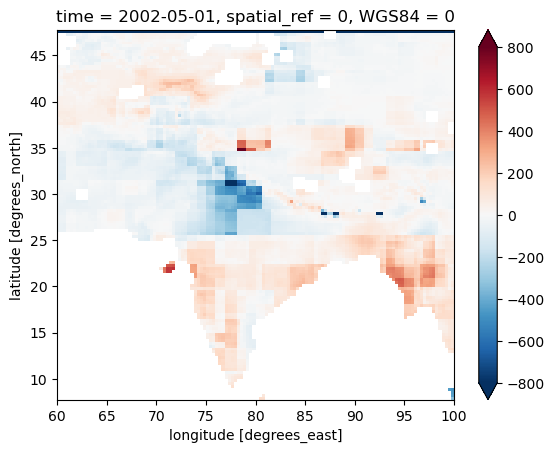

In [7]:
difference_resampled_da = da_gldas - resampled_filled_da_grace
difference_resampled_da[1,:,:].plot(vmin=-800, vmax=800, cmap='RdBu_r')

#### 6. Normalize
"The input and target images are normalized before training"

In [9]:
# dirty fix: replace the first row of the resampled GRACE dataset with the second row to get rid of a numerical error
resampled_filled_da_grace[:,0,:] = resampled_filled_da_grace[:,1,:]

In [10]:
diff_mean = difference_da.mean().item()
diff_std = difference_da.std().item()
norm_difference_da = (difference_da - diff_mean) / diff_std
norm_difference_da.attrs['diff_mean'] = diff_mean
norm_difference_da.attrs['diff_std'] = diff_std
#diff_min = difference_da.min().item()
#diff_max = difference_da.max().item()
#norm_difference_da = (difference_da - diff_min)  / (diff_max - diff_min)

clean_da_gldas = ds_gldas['twsa_gldas'] 

In [11]:
# replace nan with 1e-7 for masking in Keras
norm_difference_da = norm_difference_da.fillna(1e-7)
resampled_filled_da_grace = resampled_filled_da_grace.fillna(1e-7)
clean_da_gldas = clean_da_gldas.fillna(1e-7)

#### 7. Save

In [12]:
xr.merge(
        [norm_difference_da.to_dataset(name='norm_mismatch'), difference_da.to_dataset(name='mismatch'),
         resampled_filled_da_grace.to_dataset(name='grace'), clean_da_gldas.to_dataset(name='gldas')]
    ).to_netcdf('./data/mismatch.nc4')